In [1]:
import librosa
import matplotlib.pyplot as plt

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider,IntRangeSlider
from IPython.display import (
    Audio, display, clear_output)
from scipy import signal
from Util import *

## load sound files

In [2]:

signal0, sr = librosa.load('signal_cut.wav',sr=None)
signal1, sr1 = librosa.load('signal_cut1.wav',sr=None)
signal2, sr2 = librosa.load('signal_cut2.wav',sr=None)
display(Audio(signal0, rate=sr))
display(Audio(signal1, rate=sr))
display(Audio(signal2, rate=sr))

## setting up the modulator

In [3]:
class Modulator:
    def __init__(self,modulation,output_filter):
        self.modulation = modulation # a modulation function that depends on source index, source and time
        self.filter = output_filter
    def modulate_source(self,frequencies, sources_array,time):
        summed_output = np.zeros(len(time))
        output_array = []
        for i in range(len(sources_array)):
            sources_array[i] = signal.sosfilt(self.filter, sources_array[i])
            mod = self.modulation(frequencies[i],sources_array[i],time)
            summed_output += mod
            output_array.append(mod)
        return summed_output,output_array
    def reverse_modulation(self,freq, source,time):
        reverse = self.modulation(freq,source,time)
        
        return signal.sosfilt(self.filter, reverse)

In [4]:
cos_modulation = lambda freq,src,t: np.multiply(np.cos(2*np.pi*freq*t),src)
reverse_filter = signal.cheby1(31,5, 2500, 'lowpass', fs=44100,output='sos')


In [12]:
cosModulator = Modulator(cos_modulation,reverse_filter)

## process the sounds

In [6]:
duration=len(signal0)/sr
t=np.linspace(0,duration,int(sr*duration))

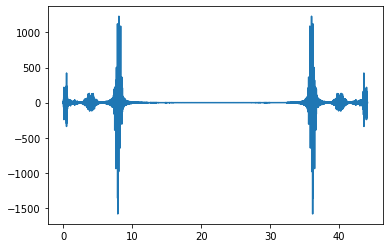

In [7]:
transmit_signal = cosModulator.modulate_source(3,[signal0,signal1,signal2],t)
ax_freq = np.arange(0,sr,sr/len(transmit_signal))*1e-3

fig,ax = plt.subplots()
ax.plot(ax_freq,np.fft.fft(transmit_signal).real)


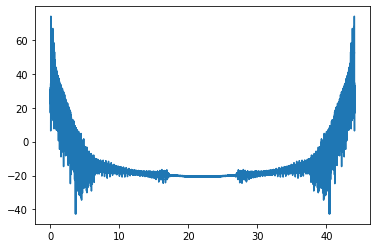

In [8]:
fig,ax = plt.subplots()
ax.plot(ax_freq,20*np.log10(abs(np.fft.fft(signal2))))

In [9]:
recieved_signal = transmit_signal

<IPython.core.display.Javascript object>


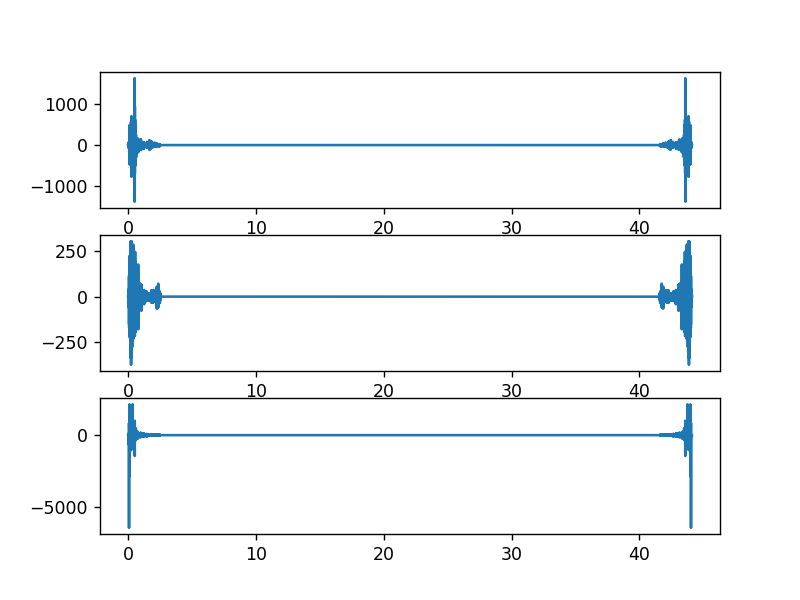

In [10]:
%matplotlib notebook
fig,ax = plt.subplots(3)
for i in range(3):
    reverse = cosModulator.reverse_modulation(i,recieved_signal,t)
    ax[i].plot(ax_freq,np.fft.fft(reverse).real)
    display(Audio(reverse, rate=sr))




In [45]:
def summary_plot(signals,transmit_array,transmit_signal,reverse_array):
    n_fft = 256
    ax_freq = np.arange(0,sr,sr/n_fft)*1e-3
    fig,ax = plt.subplots(2,2, sharex=True, sharey=True)
    signal_fft = []
    transmit_fft = []
    reverse_fft = []
    for i in range(len(signals)):
        signal_fft.append(fold_and_dft(signals[i],n_fft))
        transmit_fft.append(fold_and_dft(transmit_array[i],n_fft))
        reverse_fft.append(fold_and_dft(reverse_array[i],n_fft))
    ax[0,0].plot(ax_freq,v_to_db(signal_fft[0]),ax_freq,v_to_db(transmit_fft[0]))
    ax[0,0].plot(ax_freq,v_to_db(reverse_fft[0]))
    ax[0,0].set_ylabel('Amplitude [dB]')
    ax[0,0].set_title('signal0')
    ax[1,0].plot(ax_freq,v_to_db(signal_fft[1]),ax_freq,v_to_db(transmit_fft[1]))
    ax[1,0].plot(ax_freq,v_to_db(reverse_fft[1]))
    ax[1,0].set_ylabel('Amplitude [dB]')
    ax[1,0].set_xlabel('Frequency kHz')
    ax[1,0].set_title('signal1')
    
    ax[0,1].plot(ax_freq,v_to_db(signal_fft[2]),ax_freq,v_to_db(transmit_fft[2]))
    ax[0,1].plot(ax_freq,v_to_db(reverse_fft[2]))
    #ax[0,1].set_ylabel('Amplitude [dB]')
    ax[0,1].set_title('signal2')
    ax[1,1].plot(ax_freq,v_to_db(transmit_fft[0]))
    ax[1,1].plot(ax_freq,v_to_db(abs(transmit_fft[1])))
    ax[1,1].plot(ax_freq,v_to_db(transmit_fft[2]))
    ax[1,1].set_xlabel('Frequency kHz')
    ax[1,1].set_title('transmit_signal')
    fig.tight_layout(pad=2.0)
    plt.ylim(-60,60)
    plt.xlim(0,24)

In [47]:

cos_modulation = lambda freq,src,t: np.multiply(np.cos(2*np.pi*freq*t),src)

@interact_manual
def sound_modulation(freq1=(0,20000),freq2=(0,20000),freq3=(0,20000),LPF=(0,20000)):
    plt.rcParams['axes.grid'] = True
    %matplotlib notebook
    frequencies = [freq1,freq2,freq3]
    reverse_filter = signal.cheby1(31,1, LPF, 'lowpass', fs=44100,output='sos')
    cosModulator = Modulator(cos_modulation,reverse_filter)
    transmit_signal,transmit_array = cosModulator.modulate_source(frequencies,[signal0,signal1,signal2],t)
    reverse = []
    for i in range(3):
        reverse.append(cosModulator.reverse_modulation(frequencies[i],transmit_signal,t))
        display(Audio(reverse[i], rate=sr))
    summary_plot(signals = [signal0,signal1,signal2],transmit_array=transmit_array,transmit_signal=transmit_signal,reverse_array=reverse)

interactive(children=(IntSlider(value=10000, description='freq1', max=20000), IntSlider(value=10000, descripti…

## various filters

### LPF

In [11]:
@interact_manual
def filter(hz=(20,20000)):
    %matplotlib notebook
    sos = signal.cheby1(31,5, hz, 'lowpass', fs=44100,output='sos')
    ax_freq = np.arange(0,sr,sr/len(transmit_signal))*1e-2
    filtered_signal=signal.sosfilt(sos, transmit_signal)
    fig,ax = plt.subplots()
    ax.semilogx(ax_freq,np.fft.fft(filtered_signal).real)
    ax.axvline(x=hz/100,linestyle="--")
    plt.xlim(1,200)

interactive(children=(IntSlider(value=10010, description='hz', max=20000, min=20), Button(description='Run Int…

### HPF

In [12]:
@interact_manual
def filter(hz=(20,20000)):
    %matplotlib notebook
    sos = signal.butter(100, hz, 'highpass', fs=44100,output='sos')
    ax_freq = np.arange(0,sr,sr/len(transmit_signal))*1e-2
    filtered_signal=signal.sosfilt(sos, transmit_signal)
    fig,ax = plt.subplots()
    ax.semilogx(ax_freq,np.fft.fft(filtered_signal).real)
    ax.axvline(x=hz/100,linestyle="--")
    plt.xlim(1,200)

interactive(children=(IntSlider(value=10010, description='hz', max=20000, min=20), Button(description='Run Int…

### Bandpass

In [13]:
@interact_manual
def filter(hz=IntRangeSlider(value=[20, 20000],min=20,max=20000,step=1,description='hz range:')):
    %matplotlib notebook
    sos = signal.butter(100, hz, 'bandpass', fs=44100,output='sos')
    ax_freq = np.arange(0,sr,sr/len(transmit_signal))*1e-2
    filtered_signal=signal.sosfilt(sos, transmit_signal)
    fig,ax = plt.subplots()
    ax.semilogx(ax_freq,np.fft.fft(filtered_signal).real)
    ax.axvline(x=hz[0]/100,linestyle="--")
    ax.axvline(x=hz[1]/100,linestyle="--")
    plt.xlim(1,200)


interactive(children=(IntRangeSlider(value=(20, 20000), description='hz range:', max=20000, min=20), Button(de…

### Bandstop

In [14]:
@interact_manual
def filter(hz=IntRangeSlider(value=[20, 20000],min=20,max=20000,step=1,description='hz range:')):
    %matplotlib notebook
    sos = signal.butter(100, hz, 'bandstop', fs=44100,output='sos')
    ax_freq = np.arange(0,sr,sr/len(transmit_signal))*1e-2
    filtered_signal=signal.sosfilt(sos, transmit_signal)
    fig,ax = plt.subplots()
    ax.semilogx(ax_freq,np.fft.fft(filtered_signal).real)
    ax.axvline(x=hz[0]/100,linestyle="--")
    ax.axvline(x=hz[1]/100,linestyle="--")
    plt.xlim(1,200)

interactive(children=(IntRangeSlider(value=(20, 20000), description='hz range:', max=20000, min=20), Button(de…